In [1]:
import config
from matplotlib.pyplot import figure
import pandas as pd
import os
from Models import FeedForward, FeedForward5, LogisticRegression, LSTMPredictor, BatchOneLayerLSTM, BatchOneLayerGRU
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.set_printoptions(threshold=np.inf, suppress=False, floatmode='fixed')
torch.set_printoptions(threshold=5000)

In [59]:
hdf_file_path = '../Loan_Data_Test5.h5'
t=5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
df = pd.read_hdf(hdf_file_path, 'X_' + str(t))
lookup = pd.read_hdf(hdf_file_path, 'lookup_' + str(t)).values

In [33]:
df = df.iloc[lookup[0,1]: lookup[1,2]]
lookup = lookup[:2, :]

In [34]:
df.loc[(df.zero_balance == 1) == True, 'current_status'] = '46'
df.current_UPB = pd.to_numeric(df['current_UPB'], errors='coerce')
df.mi_recovery = pd.to_numeric(df['mi_recovery'], errors='coerce')
df.non_mi_recovery = pd.to_numeric(df['non_mi_recovery'], errors='coerce')
df.net_sales_procedees = pd.to_numeric(df['net_sales_procedees'], errors='coerce')
df.modification_cost = pd.to_numeric(df['modification_cost'], errors='coerce')
df.remaining_month = pd.to_numeric(df['remaining_month'], errors='coerce')
df.current_status = df.current_status.astype('category', categories=config.unique_values['current_status'])
df.state = df.state.astype('category', categories=config.unique_values['unique_states'])
df = pd.get_dummies(df, columns=['state'])

/home/subhankar/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/home/subhankar/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  if __name__ == '__main__':


In [35]:
X = df[config.column_list['select_columns']].values
y = pd.get_dummies(df.current_status).values
X[np.isnan(X)]=-1

In [36]:
batch_data = np.zeros((lookup.shape[0], 135, X.shape[1])) # batch, seq, features
batch_labels = -1*np.ones((lookup.shape[0], 135, y.shape[1]))
batch_data.shape, batch_labels.shape

((2, 135, 110), (2, 135, 46))

In [39]:
for ind in range(lookup.shape[0]):
    sent = X[ lookup[ind, 1]:lookup[ind, 2], :]
    label = y[ lookup[ind, 1]:lookup[ind, 2], :]
    curr_len = sent.shape[0]
    batch_data[ind, :curr_len, :] = sent
    batch_labels[ind, :curr_len, :] = label

In [62]:
X = batch_data
y_true = batch_labels
batch_data.shape, batch_labels.shape

((2, 135, 110), (2, 135, 46))

**Training**

In [89]:
input_size = 110
num_classes = len(config.unique_values['current_status'])
learning_rate = 0.001
criterion = nn.NLLLoss(ignore_index = -1) # nn.CrossEntropyLoss()
# self.criterion_lstm = nn.CrossEntropyLoss(ignore_index = -1)  
criterion_lstm = nn.NLLLoss(ignore_index = -1)
model = BatchOneLayerLSTM(input_size, 128, num_classes, device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  
num_epochs = 5
training_accuracy = np.zeros(shape=(num_epochs, 1))
test_accuracy = np.zeros(shape=(num_epochs, 1))
training_auc = np.zeros(shape=(num_epochs, 1))
test_auc = np.zeros(shape=(num_epochs, 1))
test_loss = []
loss_values = []
concerned_class = 43
data_file_name_train = '../Loan_Data_Test5.h5'
data_file_name_test = '../Loan_Data_Test5.h5'
model = model.to(device)

LSTM Model with  128  hidden units  110  input dimensions and dropout of  0.3


/home/subhankar/.conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [118]:
inputs = Variable(torch.FloatTensor(X).to(device))
y = np.argmax(y_true, axis=2)
y[y_true[:, :, 0] == -1] = -1
y_oh = Variable(torch.LongTensor(y.reshape(y.shape[0]*y.shape[1])).to(device))
optimizer.zero_grad()
outputs = model(inputs)
loss = criterion_lstm(outputs, y_oh)
loss.backward()
optimizer.step()
auc = GetAUCScore(y_true, outputs.data.cpu().numpy(), concerned_class, save_results=True)

/home/subhankar/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [116]:
def accumulate_truth(iterable):
    true = 0
    false = 0
    for i in iterable:
        if i:
            true += 1
        else:
            false += 1
        yield true, false


def home_made_ROC(scores, targets):
    total_targets = sum(targets)
    length_sub_targets = len(targets) - total_targets

    scores, targets = zip(*sorted(zip(scores, targets), reverse=True))
    tprs = []
    fprs = []
    for true, false in accumulate_truth(targets):
        tprs.append(true / total_targets)
        fprs.append(false / length_sub_targets)
    return tprs, fprs


def home_made_AUC(TPR, FPR):
    dFPR = np.zeros(len(FPR))
    dTPR = np.zeros(len(TPR))
    dFPR[:-1] = np.diff(FPR)
    dTPR[:-1] = np.diff(TPR)
    auc_val = np.sum(TPR * dFPR) + (np.sum(dTPR * dFPR)/2)
    if np.isnan(auc_val):
        return 0
    return auc_val


def GetAUCScore(y_actual, predicted_score, concerned_class, is_transition=False, save_results=False):
    ### y_actual: one hot encoding of all classes. np array of shape n x num_of_classes
    ### predicted_score: np array of shape n x num_of_classes containing probabilities
    ### PrintMatrix(predicted_score)
    # print(np.min(predicted_score), np.max(predicted_score))
    try:
    # print(predicted_score[:100, 0])
    # print('#################################')
    # print('########## class 0 #################')
    # print('#################################')
        if is_transition:
            ii = np.where(y_actual[:, 0] == 1)[0]
            ii = ii + 1
            ii = ii[ii < y_actual.shape[0]]
            y_actual = y_actual[ii, :]
            predicted_score = predicted_score[ii, :]
        predicted_score = predicted_score[:, concerned_class]
        y_actual = y_actual[:, concerned_class]
        valid_index = (y_actual != -1)
        y_actual = y_actual[valid_index]
        # print('Number of positive samples: ', np.sum(y_actual), 'total: ', y_actual.shape)
        # y_actual = y_actual[:, concerned_class]
        predicted_score = predicted_score[valid_index]
        if save_results:
            res = np.vstack((y_actual, predicted_score))
            np.save('res_'+str(concerned_class)+'_'+str(random.randint(0, 10000))+'.npy', res)
        # print(roc_auc_score(y_actual, predicted_score), y_actual[y_actual == 1].shape, y_actual.shape)
#         print(y_actual[:100])
#         print('#################################')
#         print('########### actual class 1 ###############')
#         print('#################################')
#         print(predicted_score[:100,])
#         print('#################################')
#         print('############ class 1 ############')
#         print('#################################')
        tprs, fprs = home_made_ROC(predicted_score, y_actual)
        return home_made_AUC(tprs, fprs)
        # return roc_auc_score(y_actual, predicted_score)
    except Exception as e:
        print("Error", e)
        # print(predicted_score)
        return 0


In [81]:
res.shape

(2, 25332)

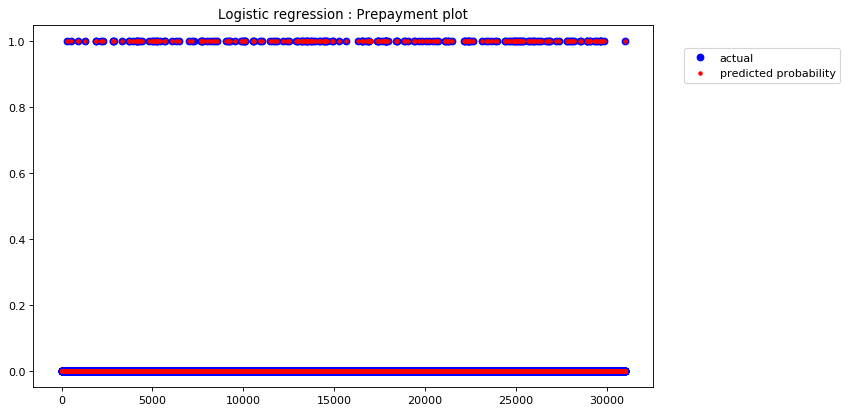

In [97]:
figure(num=None, figsize=(10, 6), dpi=80)
res = np.load('./ResultLR/res_43_4901.npy')
num = res.shape[1]//2
actual = res[0, :]
prob = res[1, :]
act = plt.plot(actual, 'bo')
pr = plt.plot(np.exp(prob), 'r.')
lns = act + pr
labels = ['actual', 'predicted probability']
plt.legend(lns, labels, loc='upper right', bbox_to_anchor=(1.31, 1-0.05))
plt.title('Logistic regression : Prepayment plot')
plt.savefig('LR5.png')
plt.show()